# Dependancy Installs

In [29]:
!python -V
!pip install nltk
!pip install scikit-learn
!pip install transformers
!pip install tensorflow
!pip install pyyaml h5py
!pip install matplotlib

Python 3.7.12


# Read Training Data

In [ ]:
#from google.colab import drive
#drive.mount("/content/drive/")

In [ ]:
#!cat '/content/drive/My Drive/MSC_Project/train.json'

In [30]:
import json
import os
from sklearn.model_selection import train_test_split

class RawData(object):
    def __init__(self, id, intent, positions, slots, text):
        self.id = id
        self.intent = intent
        self.positions = positions
        self.slots = slots
        self.text = text

    def __repr__(self):
        return str(json.dumps(self.__dict__, indent=2))


"""
reads json from data file
returns a list containing DataInstance objects
"""


def read_train_json_file(filename):
    if os.path.exists(filename):
        intents = []

        with open(filename, "r", encoding="utf-8") as json_file:
            data = json.load(json_file)

            for k in data.keys():
                intent = data[k]["intent"]
                positions = data[k]["positions"]
                slots = data[k]["slots"]
                text = data[k]["text"]

                temp = RawData(k, intent, positions, slots, text)
                intents.append(temp)

        return intents
    else:
        raise FileNotFoundError("No file found with that path!")

# read from json file
all_data = read_train_json_file("train.json")

train_data ,test_data = train_test_split(all_data,test_size=0.2, shuffle=True)

#train_data[:-2]

In [31]:
print(len(train_data), len(test_data))

120 30


# Preparations for Model

In [32]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [33]:

def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    cleaned = emoji_pattern.sub(r'', text)
    return re.sub(' +', ' ', cleaned.strip())

def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  filtered_sentence = []
  for w in word_tokens:
      if w not in stop_words:
          filtered_sentence.append(w)
  return " ".join(filtered_sentence)

def pre_process_text(text):
  return remove_emojis(remove_stopwords(text))

print(pre_process_text("  build, test, deploy to staging,    deploy to production 😀 using t2.micro EC2 "))

build , test , deploy staging , deploy production using t2.micro EC2


In [68]:
# Tokenizer
import tensorflow as tf
from transformers import AutoTokenizer
# from transformers import BertTokenizer

model_name = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def encode_texts(tokenizer, texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="tf") # is_split_into_words=True,

texts = [d.text for d in train_data]
encoded_texts = encode_texts(tokenizer, texts)
encoded_texts.keys()


test_texts = [d.text for d in test_data]
test_encoded_texts = encode_texts(tokenizer, texts)

In [35]:
encoded_texts.get(0)

Encoding(num_tokens=43, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [36]:
intents = [d.intent for d in train_data]
intent_names = list(set(intents))
intent_names

['capture_cloud_provider',
 'capture_keypair',
 'declare_stages',
 'capture_only_except_condition',
 'declare_region',
 'capture_instance_os',
 'capture_instance_type',
 'capture_framework_name',
 'capture_app_name',
 'capture_env_variables']

In [65]:
test_intents = [d.intent for d in test_data]
test_intent_names = list(set(intents))
test_intent_names

['capture_cloud_provider',
 'capture_keypair',
 'declare_stages',
 'capture_only_except_condition',
 'declare_region',
 'capture_instance_os',
 'capture_instance_type',
 'capture_framework_name',
 'capture_app_name',
 'capture_env_variables']

In [37]:
intent_map = dict() # index -> intent
for idx, ui in enumerate(intent_names):
    intent_map[ui] = idx
intent_map

{'capture_app_name': 8,
 'capture_cloud_provider': 0,
 'capture_env_variables': 9,
 'capture_framework_name': 7,
 'capture_instance_os': 5,
 'capture_instance_type': 6,
 'capture_keypair': 1,
 'capture_only_except_condition': 3,
 'declare_region': 4,
 'declare_stages': 2}

In [38]:
# map to train_data values
def encode_intents(intents, intent_map):
    encoded = []
    for i in intents:
        encoded.append(intent_map[i])
    # convert to tf tensor
    return tf.convert_to_tensor(encoded, dtype="int32")

encoded_intents = encode_intents(intents, intent_map)

In [66]:
test_encoded_intents = encode_intents(test_intents, intent_map)

In [39]:
# encode slots
slot_names = set()
for td in train_data:
    slots = td.slots
    for slot in slots:
        slot_names.add(slot)
slot_names = list(slot_names)
slot_names.insert(0, "<PAD>")
slot_names

['<PAD>',
 'instance_os',
 'framework_name',
 'only_condition',
 'region',
 'env_variables',
 'keypair',
 'instance_type',
 'except_condition',
 'app_name',
 'names_of_stages',
 'cloud_provider']

In [40]:
slot_map = dict() # slot -> index
for idx, us in enumerate(slot_names):
    slot_map[us] = idx
slot_map

{'<PAD>': 0,
 'app_name': 9,
 'cloud_provider': 11,
 'env_variables': 5,
 'except_condition': 8,
 'framework_name': 2,
 'instance_os': 1,
 'instance_type': 7,
 'keypair': 6,
 'names_of_stages': 10,
 'only_condition': 3,
 'region': 4}

In [41]:
# gets slot name from its values
def get_slot_from_word(word, slot_dict):
    for slot_label,value in slot_dict.items():
        if word in value.split():
            return slot_label
    return None

print(train_data[0].text)
print(train_data[0].slots)
print("slot_name for nodejs-app-test1 is : ", get_slot_from_word("nodejs-app-test1", train_data[0].slots))

application is Python-Load-Manager
{'app_name': 'Python-Load-Manager'}
slot_name for nodejs-app-test1 is :  None


In [42]:
import numpy as np

# find the max encoded test length
# tokenizer pads all texts to same length anyway so
# just get the length of the first one's input_ids
max_len = len(encoded_texts["input_ids"][0])

def encode_slots(all_slots, all_texts, 
                 toknizer, slot_map, max_len=max_len):
    encoded_slots = np.zeros(shape=(len(all_texts), max_len), dtype=np.int32)
    
    for idx, text in enumerate(all_texts):
        enc = [] # for this idx, to be added at the end to encoded_slots
        
        # slot names for this idx
        slot_names = all_slots[idx]
        
        # raw word tokens
        # not using bert for this block because bert uses
        # a wordpiece tokenizer which will make 
        # the slot label to word mapping
        # difficult
        raw_tokens = text.split()

        # words or slot_values associated with a certain
        # slot_name are contained in the values of the
        # dict slots_names
        # now this becomes a two way lookup
        # first we check if a word belongs to any
        # slot label or not and then we add the value from
        # slot map to encoded for that word
        for rt in raw_tokens:
            # use bert tokenizer
            # to get wordpiece tokens
            bert_tokens = tokenizer.tokenize(rt)
            
            # find the slot name for a token
            rt_slot_name = get_slot_from_word(rt, slot_names)
            if rt_slot_name is not None:
                # fill with the slot_map value for all ber tokens for rt
                enc.append(slot_map[rt_slot_name])
                enc.extend([slot_map[rt_slot_name]] * (len(bert_tokens) - 1))

            else:
                # rt is not associated with any slot name
                enc.append(0)

        
        # now add to encoded_slots
        # ignore the first and the last elements
        # in encoded text as they're special chars
        encoded_slots[idx, 1:len(enc)+1] = enc
    
    return encoded_slots
    

In [43]:
all_slots = [td.slots for td in train_data]
all_texts = [td.text for td in train_data]
encoded_slots = encode_slots(all_slots, all_texts, tokenizer, slot_map)

encoded_slots[0]

array([0, 0, 0, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [ ]:
test_all_slots = [td.slots for td in test_data]
test_all_texts = [td.text for td in test_data]
test_encoded_slots = encode_slots(test_all_slots, test_all_texts, tokenizer, slot_map)

test_encoded_slots[0]

# Fit Model

In [44]:
from transformers import TFBertModel
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras import activations

class JointIntentAndSlotFillingModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, slot_num_labels=None,
                 model_name=model_name, dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFBertModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)
        self.intent_classifier = Dense(intent_num_labels,
                                       name="intent_classifier",
                                       activation=activations.softmax)
        self.slot_classifier = Dense(slot_num_labels,
                                     name="slot_classifier",
                                     activation=activations.softmax)

    def call(self, inputs, **kwargs):
        # two outputs from BERT
        trained_bert = self.bert(inputs, **kwargs)
        pooled_output = trained_bert.pooler_output
        sequence_output = trained_bert.last_hidden_state
        
        # sequence_output will be used for slot_filling / classification
        sequence_output = self.dropout(sequence_output,
                                       training=kwargs.get("training", False))
        slot_logits = self.slot_classifier(sequence_output)

        # pooled_output for intent classification
        pooled_output = self.dropout(pooled_output,
                                     training=kwargs.get("training", False))
        intent_logits = self.intent_classifier(pooled_output)

        return slot_logits, intent_logits

In [45]:
joint_model = JointIntentAndSlotFillingModel(
    intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))

opt = Adam(learning_rate=3e-5, epsilon=1e-08)

# two outputs, one for slots, another for intents
# we have to fine tune for both
losses = [SparseCategoricalCrossentropy(),
          SparseCategoricalCrossentropy()]

metrics = [SparseCategoricalAccuracy("accuracy")]
# compile model
joint_model.compile(optimizer=opt, loss=losses, metrics=metrics)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [46]:
encoded_texts["input_ids"][None: ].shape

TensorShape([120, 43])

In [47]:
# from sklearn.model_selection import train_test_split
# import numpy as np
# from pprint import pprint

# x = {"input_ids": encoded_texts["input_ids"], "token_type_ids": encoded_texts["token_type_ids"],  "attention_mask": encoded_texts["attention_mask"]}

# print(tokenizer(['I want to deploy my-service', 'use build,test, prod as stages'], padding=True, truncation=True, return_tensors="tf"))
# pprint(encoded_texts["input_ids"])
# print(encoded_intents.shape)
# for i,j in zip(encoded_slots,encoded_intents):
#   print(i,j)

# print(len(np.asarray(x)))

# create x
# x = [(input_ids, token_type_ids, att_masks) for input_ids, token_type_ids, att_masks in zip(encoded_texts["input_ids"], encoded_texts["token_type_ids"], encoded_texts["attention_mask"])]

# print(x[0])
# x_train, x_test, y_train, y_test = train_test_split(
#                                             encoded_texts["input_ids"][None: ], 
#                                             encoded_slots , 
#                                             test_size = 0.2, 
#                                             random_state = 1
#                                     )

# print(x_test)
# print(len(x_train), len(x_test), len(y_train), len(y_test))

In [48]:
x = {"input_ids": encoded_texts["input_ids"], "token_type_ids": encoded_texts["token_type_ids"],  "attention_mask": encoded_texts["attention_mask"]}

history = joint_model.fit(
    x, (encoded_slots, encoded_intents), epochs=15, batch_size=4, shuffle=True) # , validation_split = 0.2

Epoch 1/15
30/30 [==============================] - 92s 3s/step - loss: 3.3834 - output_1_loss: 0.8505 - output_2_loss: 2.5329 - output_1_accuracy: 0.8060 - output_2_accuracy: 0.1583
Epoch 2/15
30/30 [==============================] - 74s 2s/step - loss: 1.9391 - output_1_loss: 0.3116 - output_2_loss: 1.6275 - output_1_accuracy: 0.9382 - output_2_accuracy: 0.4500
Epoch 3/15
30/30 [==============================] - 72s 2s/step - loss: 1.0667 - output_1_loss: 0.2272 - output_2_loss: 0.8395 - output_1_accuracy: 0.9463 - output_2_accuracy: 0.7667
Epoch 4/15
30/30 [==============================] - 66s 2s/step - loss: 0.4550 - output_1_loss: 0.1688 - output_2_loss: 0.2862 - output_1_accuracy: 0.9612 - output_2_accuracy: 0.9500
Epoch 5/15
30/30 [==============================] - 73s 2s/step - loss: 0.2272 - output_1_loss: 0.1178 - output_2_loss: 0.1093 - output_1_accuracy: 0.9690 - output_2_accuracy: 0.9917
Epoch 6/15
30/30 [==============================] - 73s 2s/step - loss: 0.1278 - outp

In [49]:
history.history.keys()

dict_keys(['loss', 'output_1_loss', 'output_2_loss', 'output_1_accuracy', 'output_2_accuracy'])

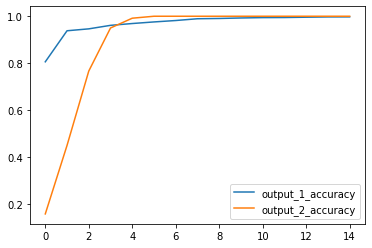

In [50]:
history.history

import matplotlib.pyplot as plt
# plot the accuracy of the model as it trains
plt.plot(history.history['output_1_accuracy'])
plt.plot(history.history['output_2_accuracy'])
plt.legend(['output_1_accuracy', 'output_2_accuracy'])

# plt.plot(history.history['val_output_1_accuracy'])
# plt.plot(history.history['val_output_2_accuracy'])
# plt.legend(['output_1_accuracy', 'output_2_accuracy', 'validation_output_1_accuracy', 'validation_output_2_accuracy'])

In [51]:
# history.history

In [52]:
history.history

import matplotlib.pyplot as plt
# plot the accuracy of the model as it trains
plt.plot(history.history['val_output_1_accuracy'])
plt.plot(history.history['val_output_2_accuracy'])
# plt.plot(history.history['output_1_loss'])
# plt.plot(history.history['output_2_loss'])
plt.legend(['validation_output_1_accuracy', 'validation_output_2_accuracy'])

KeyError: ignored

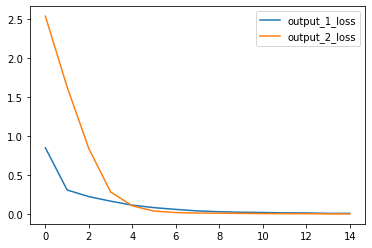

In [53]:
history.history

import matplotlib.pyplot as plt
# plot the accuracy of the model as it trains
plt.plot(history.history['output_1_loss'])
plt.plot(history.history['output_2_loss'])
# plt.plot(history.history['output_1_loss'])
# plt.plot(history.history['output_2_loss'])
plt.legend(['output_1_loss', 'output_2_loss'])

In [ ]:
history.history

import matplotlib.pyplot as plt
# plot the accuracy of the model as it trains
plt.plot(history.history['val_output_1_loss'])
plt.plot(history.history['val_output_2_loss'])
# plt.plot(history.history['output_1_loss'])
# plt.plot(history.history['output_2_loss'])
plt.legend(['val_output_1_loss', 'val_output_2_loss'])

In [ ]:
# f = joint_model.evaluate( x, (encoded_slots, encoded_intents) )
# print(f)

In [ ]:
# print(eval)

# import matplotlib.pyplot as plt
# plot the accuracy of the model as it trains
# plt.plot(history.history['output_1_accuracy'])
# plt.plot(history.history['output_2_accuracy'])
# plt.legend(['output_1_accuracy', 'output_2_accuracy'])

In [ ]:
# Save the entire model as a SavedModel.
#!mkdir -p saved_model
#joint_model.save('saved_model/my_model')
# intent_map

In [54]:
joint_model.summary()

# new_model = tf.keras.models.load_model('saved_model/my_model')

Model: "joint_intent_slot"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_1 (TFBertMode  multiple                 108310272 
 l)                                                              
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 intent_classifier (Dense)   multiple                  7690      
                                                                 
 slot_classifier (Dense)     multiple                  9228      
                                                                 
Total params: 108,327,190
Trainable params: 108,327,190
Non-trainable params: 0
_________________________________________________________________


In [56]:
def nlu(text, tokenizer, model, intent_names, slot_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    outputs = model(inputs)
    slot_logits, intent_logits = outputs

    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, :]
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]

    info = {"intent": intent_names[intent_id], "slots": {}}

    out_dict = {}
    # get all slot names and add to out_dict as keys
    predicted_slots = set([slot_names[s] for s in slot_ids if s != 0])
    for ps in predicted_slots:
      out_dict[ps] = []

    tokens = tokenizer.tokenize(text, add_special_tokens=True)

    # check if the text starts with a small letter
    # if text[0].islower():
    #   tokens = tokenizer.tokenize(text, add_special_tokens=True)
    # else:
    #   tokens = tokenizer.tokenize(text)
    for token, slot_id in zip(tokens, slot_ids):
        # add all to out_dict
        slot_name = slot_names[slot_id]

        if slot_name == "<PAD>":
            continue

        # collect tokens
        collected_tokens = [token]
        idx = tokens.index(token)

        # see if it starts with ##
        # then it belongs to the previous token
        if token.startswith("##"):
          # check if the token already exists or not
          if tokens[idx - 1] not in out_dict[slot_name]:
            collected_tokens.insert(0, tokens[idx - 1])

        # add collected tokens to slots
        out_dict[slot_name].extend(collected_tokens)

    # process out_dict
    for slot_name in out_dict:
        tokens = out_dict[slot_name]
        slot_value = tokenizer.convert_tokens_to_string(tokens)

        info["slots"][slot_name] = slot_value.strip()

    return info


In [57]:
# def nlu(text, tokenizer, model, intent_names, slot_names):

nlu("i want to deploy Nodejs-Todo-App 😀", tokenizer, joint_model, intent_names, slot_names)

{'intent': 'capture_app_name', 'slots': {'app_name': 'Nodejs - Todo - App'}}

In [58]:
nlu("environment variables are USER=db_user1, OTHER=gfh!23gf", tokenizer, joint_model, intent_names, slot_names)

{'intent': 'capture_env_variables',
 'slots': {'env_variables': 'USER = db _ user1, OTHER = gfh! 23gf'}}

In [59]:
nlu("using Django framework", tokenizer, joint_model, intent_names, slot_names)

{'intent': 'capture_framework_name', 'slots': {'framework_name': 'Djan'}}

In [ ]:
# inputs = tf.constant(tokenizer.encode("I want to deploy micro-to-do-list"))[None, :]
# slot_logits, intent_logits = joint_model(inputs)
# print(slot_logits)

# print( intent_logits)

# Save Model

In [60]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "saved_model/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Save the weights using the `checkpoint_path` format
joint_model.save_weights(checkpoint_path.format(epoch=0))

#joint_model.save_weights('path_to_my_weights',save_format='tf')

In [61]:
os.listdir(checkpoint_dir)

['cp-0000.ckpt.data-00000-of-00001', 'cp-0000.ckpt.index', 'checkpoint']

In [62]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'saved_model/cp-0000.ckpt'

In [ ]:
# Recreate the exact same model purely from the file
from tensorflow import keras
loaded_model = JointIntentAndSlotFillingModel(
    intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))
loaded_model.load_weights(latest)

In [ ]:
nlu("please deploy NodeJS-Visual-Tool", tokenizer, loaded_model, 
    intent_names, slot_names)

In [ ]:
nlu("I want to deploy active-service using build,test,deploy stages", tokenizer, loaded_model, intent_names, slot_names)

# Test Things

In [ ]:
def nlu_test(text, tokenizer, model, intent_names, slot_names):
    en = tf.constant(tokenizer.encode(text))
    # print(en)
    inputs = tf.constant(tokenizer.encode(text))[None, :]
    # print(inputs)
    # print(tokenizer.decode(en))
    # inputs = tf.constant(tokenizer.encode(text))[None, :] 
    outputs = model(inputs)
    print(outputs)
    slot_logits, intent_logits = outputs

nlu_test("please deploy visual-tool", tokenizer, loaded_model, intent_names, slot_names)

In [ ]:
# download model
!zip -r model.zip ./saved_model

In [ ]:
!ls -lah

In [ ]:
# from google.colab import files
# files.download("./model.zip")

### Evaluate

In [63]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [72]:
x_test = {"input_ids": test_encoded_texts["input_ids"], "token_type_ids": test_encoded_texts["token_type_ids"],  "attention_mask": test_encoded_texts["attention_mask"]}

test_intents= []
output_intent = []
for item in test_data:
  test_intents.append(item.intent)
  result = nlu(item.text, tokenizer, joint_model, intent_names, slot_names)
  output_intent.append(result["intent"])

output_intent[0]


'capture_instance_type'

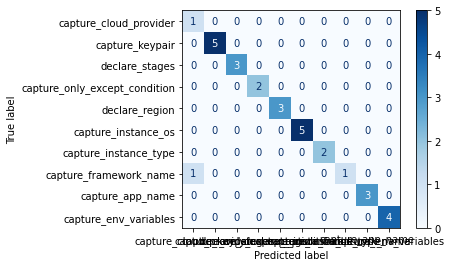

In [73]:
cm = confusion_matrix(test_intents, output_intent)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=intent_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [94]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
f1_score(test_intents, output_intent, average='weighted')
precision_recall_fscore_support(test_intents, output_intent, average='weighted')

(0.9833333333333333, 0.9666666666666667, 0.9666666666666667, None)

In [95]:
test_slots= []
output_slots = []
for item in test_data:
  # print(list(item.slots.keys())[0])
  test_slots.append(item.slots.get(list(item.slots.keys())[0]))
  result = nlu(item.text, tokenizer, joint_model, intent_names, slot_names)
  if result["slots"]:
    output_slots.append(result["slots"].get(list(result["slots"].keys())[0]))
  else:
    output_slots.append("")
  print(result["slots"])
# test_slots
# output_slots

[]

In [100]:
test_slots= []
output_slots = []
for item in test_data:
  # print(list(item.slots.keys())[0])
  test_slots.append(list(item.slots.keys())[0])
  result = nlu(item.text, tokenizer, joint_model, intent_names, slot_names)
  if result["slots"]:
    output_slots.append(list(result["slots"].keys())[0])
  else:
    output_slots.append("")
test_slots

['instance_type',
 'instance_type',
 'keypair',
 'names_of_stages',
 'framework_name',
 'cloud_provider',
 'keypair',
 'names_of_stages',
 'env_variables',
 'only_condition',
 'names_of_stages',
 'instance_type',
 'region',
 'region',
 'instance_os',
 'names_of_stages',
 'cloud_provider',
 'region',
 'instance_os',
 'instance_os',
 'cloud_provider',
 'env_variables',
 'cloud_provider',
 'instance_type',
 'framework_name',
 'cloud_provider',
 'env_variables',
 'app_name',
 'only_condition',
 'instance_type']

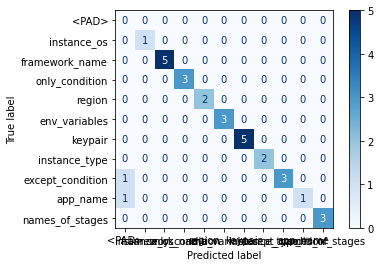

In [101]:
cm_slots = confusion_matrix(test_slots, output_slots)

disp_slots = ConfusionMatrixDisplay(confusion_matrix=cm_slots, display_labels=slot_names)

disp_slots.plot(cmap=plt.cm.Blues)
plt.show()